/var/folders/_y/wkkvhmwx35d21909d57t5dkc0000gr/T/ipykernel_10678/3465954912.py:17: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(log_console=True, use_cache=True)



--- Fetching Data for: Galway, Ireland ---

Fetching boundary for Galway...
Boundary fetched.

Fetching 'all' network graph...
Network download complete.

Fetching buildings...
Downloaded 36099 building features.

Fetching water features (including coastline, sea)...
Downloaded 191 water features.

Fetching green spaces/parks...
Downloaded 2227 green space features.

Fetching farmland areas...
Downloaded 26 farmland features.

Fetching railways...
Downloaded 32 railway line features.

Fetching place names...
Downloaded 118 place name features.

Converting graph to GeoDataFrames...
Graph converted.

Identifying road intersections (nodes with degree > 2) and their types...
Identified 14852 intersections.

Intersection DataFrame head:
   node_id   latitude  longitude  degree intersection_type
0  4837166  53.273268  -8.962934       6      uncontrolled
1  4837179  53.271665  -8.973177       8      uncontrolled
2  4837180  53.275515  -8.982765       6        signalized
3  4837190  53.272072

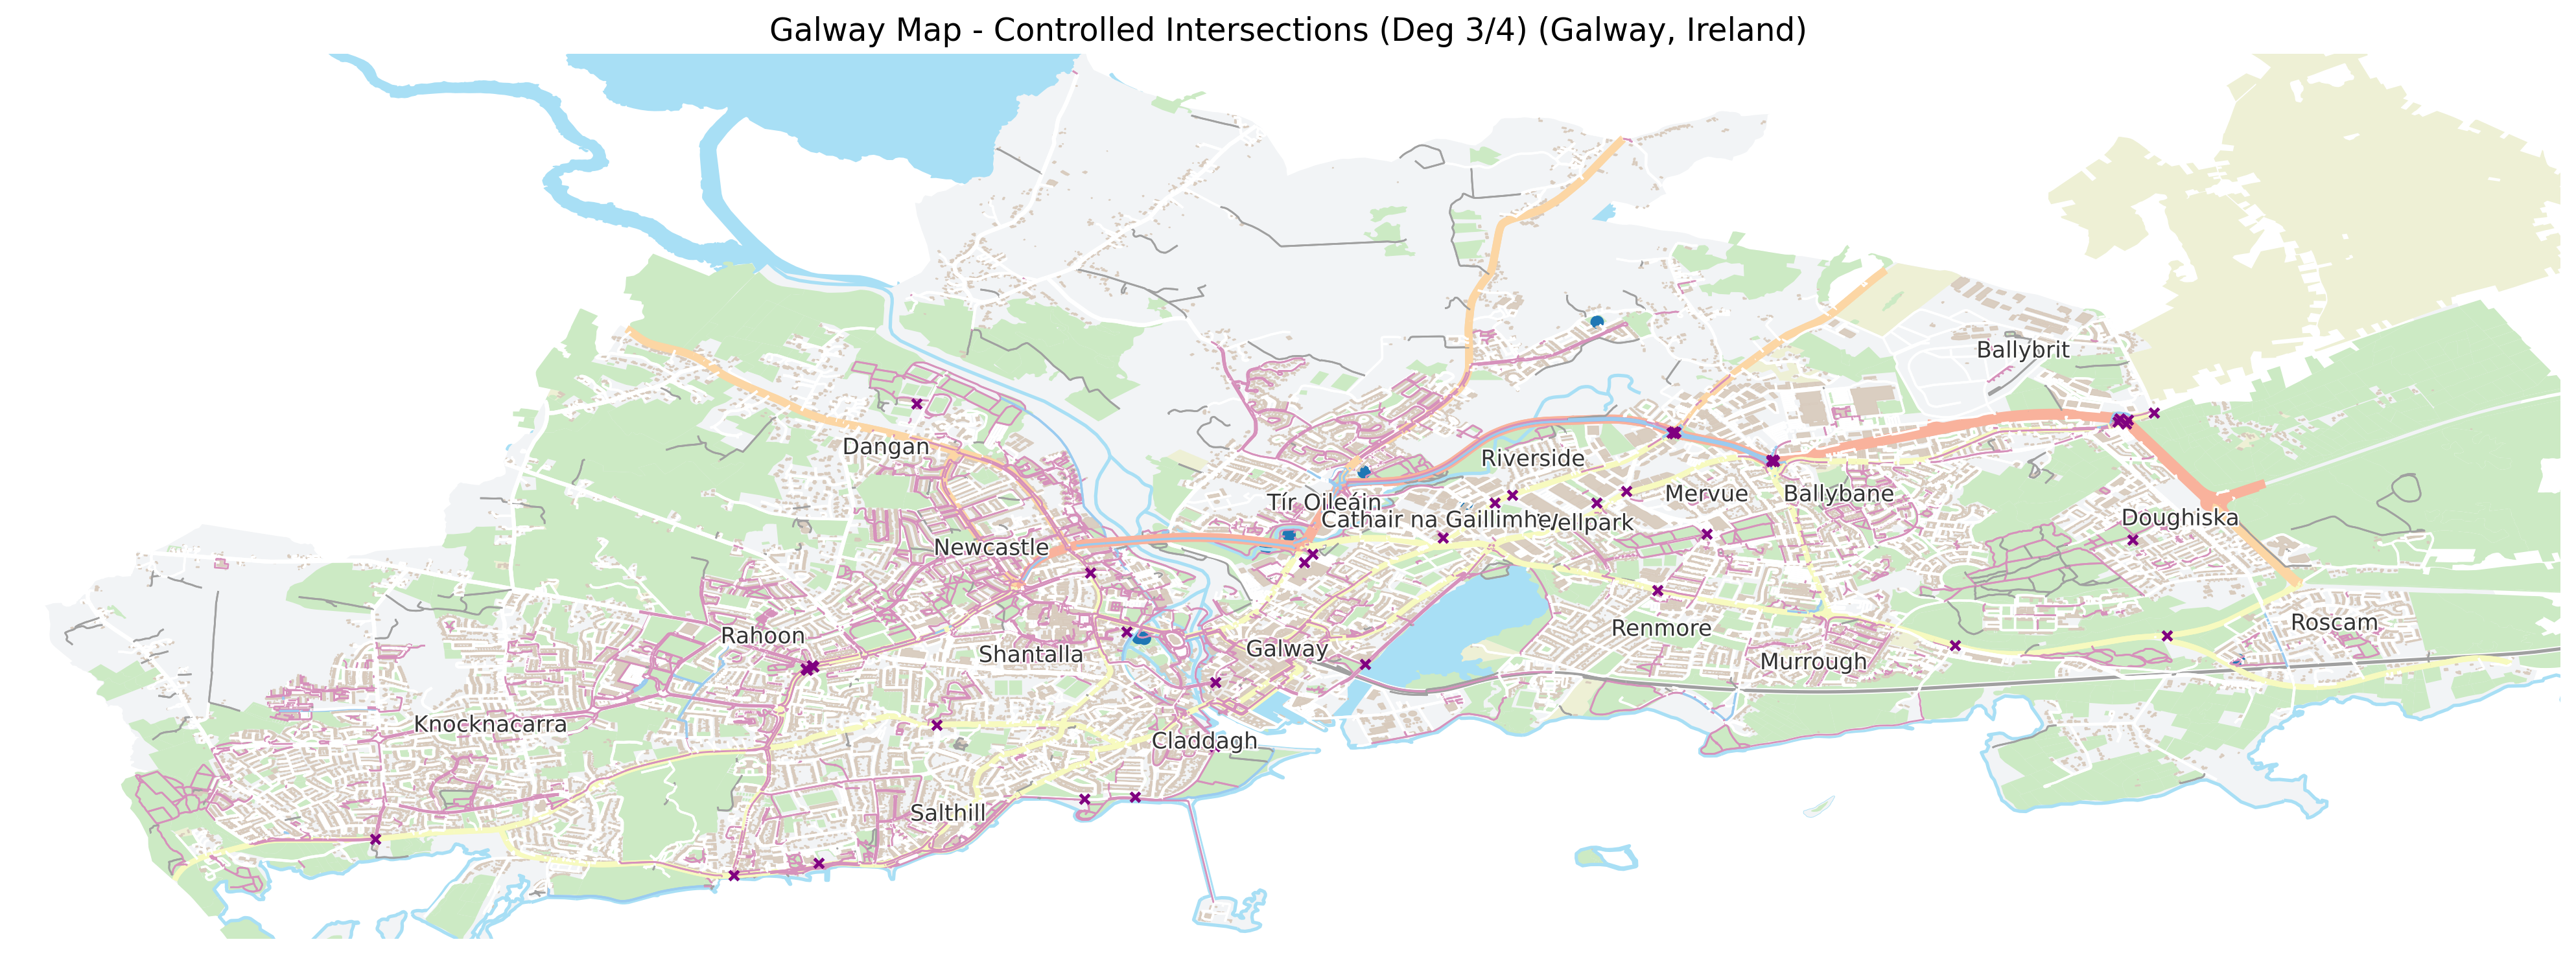


Plot displayed.


In [2]:
# !pip install matplotlib 
# !pip install osmnx 
# ! pip install lxml
# ! pip install openstreetmap
# ! pip install osmnx==1.9.3

import osmnx as ox
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
import logging
import warnings # Import warnings module
import matplotlib.patheffects # Import patheffects explicitly

# Configure osmnx settings and logging
ox.config(log_console=True, use_cache=True)
logging.basicConfig(level=logging.INFO)
# Suppress specific Matplotlib warnings about PathEffects
warnings.filterwarnings("ignore", message="The use of PathEffects")

# Define the place of interest
place_name = "Galway, Ireland"

print(f"\n--- Fetching Data for: {place_name} ---")

try:
    # --- Get Galway Boundary first ---
    print("\nFetching boundary for Galway...")
    boundary_gdf = ox.geocode_to_gdf(place_name)
    print("Boundary fetched.")
    polygon = boundary_gdf['geometry'].iloc[0] # Extract polygon

    # --- Download Network and Features ---
    print("\nFetching 'all' network graph...")
    # Using simplify=True for cleaner topology, typical for visualization
    # Handle potential Overpass API node limit error by trying a smaller area if needed
    try:
        # Get the graph (simplified is fine for degree calculation and basic tags)
        G = ox.graph_from_polygon(polygon, network_type='all', simplify=True)
    except Exception as e:
        # Check for variations of the node limit error message
        node_limit_msgs = ["WayInPolygon查询需要超过50000个节点", # Chinese message sometimes seen
                           "query returned too many nodes",       # Common English message
                           "request resulted in more nodes"]      # Another possible variation
        if any(msg in str(e) for msg in node_limit_msgs):
             print("\nWarning: Original query area likely exceeded node limit. Trying a smaller area: Galway City Centre")
             place_name = "Galway City Centre, Ireland" # Update place name for title
             boundary_gdf = ox.geocode_to_gdf(place_name)
             polygon = boundary_gdf['geometry'].iloc[0] # Get new polygon
             G = ox.graph_from_polygon(polygon, network_type='all', simplify=True) # Retry with new polygon
        else:
            raise e # Re-raise other exceptions
    print("Network download complete.")


    # --- Fetch other features within the boundary polygon ---
    # (Fetching buildings, water, parks, etc. - code unchanged)
    print("\nFetching buildings...")
    tags_buildings = {'building': True}
    buildings = ox.features_from_polygon(polygon, tags_buildings)
    buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]
    print(f"Downloaded {len(buildings)} building features.")

    print("\nFetching water features (including coastline, sea)...")
    tags_water = {'natural': ['water', 'coastline', 'sea'],
                  'waterway': ['riverbank', 'dock', 'canal', 'river'],
                  'landuse': ['basin', 'reservoir'],
                  'water': True}
    water = ox.features_from_polygon(polygon, tags_water)
    print(f"Downloaded {len(water)} water features.")

    print("\nFetching green spaces/parks...")
    tags_parks = {'leisure': ['park', 'nature_reserve', 'golf_course', 'pitch', 'garden', 'playground'],
                  'landuse': ['forest', 'grass', 'meadow', 'recreation_ground', 'greenfield', 'orchard', 'village_green', 'cemetery'],
                  'natural': ['wood', 'grassland', 'scrub', 'heath']}
    parks = ox.features_from_polygon(polygon, tags_parks)
    print(f"Downloaded {len(parks)} green space features.")

    print("\nFetching farmland areas...")
    tags_farmland = {'landuse': ['farmland', 'farmyard']}
    farmland = ox.features_from_polygon(polygon, tags_farmland)
    print(f"Downloaded {len(farmland)} farmland features.")

    print("\nFetching railways...")
    tags_railways = {'railway': ['rail', 'light_rail', 'tram']}
    railways = ox.features_from_polygon(polygon, tags_railways)
    if not railways.empty:
        railways = railways[railways.geometry.type == 'LineString']
    print(f"Downloaded {len(railways)} railway line features.")

    print("\nFetching place names...")
    tags_places = {'place': ['city', 'town', 'suburb', 'neighbourhood', 'quarter', 'islet', 'locality']}
    places = ox.features_from_polygon(polygon, tags_places)
    if not places.empty:
        places = places[places['name'].notna() & places.geometry.notna()]
    print(f"Downloaded {len(places)} place name features.")


    # --- Get Node and Edge GeoDataFrames ---
    print("\nConverting graph to GeoDataFrames...")
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    print("Graph converted.")

    if gdf_edges.empty:
        print("\nError: No road network edges were found. Cannot proceed.")
        raise ValueError("No road network data found.")


    # --- Function to Determine Intersection Type ---
    def get_intersection_type(node_data):
        """Determines intersection type based on OSM tags in node data."""
        if node_data.get('junction') in ['roundabout', 'circular']: return 'roundabout'
        if node_data.get('highway') == 'mini_roundabout': return 'mini_roundabout'
        if node_data.get('highway') == 'traffic_signals': return 'signalized'
        if node_data.get('highway') == 'crossing' and node_data.get('crossing') == 'traffic_signals': return 'signalized_crossing'
        return 'uncontrolled'


    # --- Identify Intersections and Determine Type ---
    print("\nIdentifying road intersections (nodes with degree > 2) and their types...")
    intersection_nodes = []
    for node, data in G.nodes(data=True):
        degree = G.degree(node)
        if degree > 2:
            intersection_type = get_intersection_type(data)
            intersection_nodes.append({
                'node_id': node, 'latitude': data['y'], 'longitude': data['x'],
                'degree': degree, 'intersection_type': intersection_type
            })
    intersections_df = pd.DataFrame(intersection_nodes)

    if intersections_df.empty: print("Warning: No intersections found (nodes with degree > 2).")
    else:
        print(f"Identified {len(intersections_df)} intersections.")
        print("\nIntersection DataFrame head:"); print(intersections_df.head())
        print("\nIntersection Type Frequencies:"); print(intersections_df['intersection_type'].value_counts())


    # --- Prepare Edge Colors and Widths ---
    print("\nPreparing edge colors and linewidths for OSM style...")
    # (Color and Linewidth mapping code - unchanged)
    color_map = {
        'motorway':     '#e892a2', 'trunk':        '#f9b29c', 'primary':      '#fcd6a4',
        'secondary':    '#f7fabf', 'tertiary':     '#ffffff', 'residential':  '#ffffff',
        'unclassified': '#ffffff', 'service':      '#ffffff', 'living_street':'#ffffff',
        'cycleway':     '#9acbf0', 'footway':      '#d691bb', 'pedestrian':   '#f0f0f0',
        'path':         '#a0a0a0', 'steps':        '#a0a0a0', 'track':        '#a0a0a0',
    }
    linewidth_map = {
        'motorway':     4.5, 'trunk':        4.0, 'primary':      3.5, 'secondary':    2.5,
        'tertiary':     1.8, 'residential':  1.2, 'unclassified': 1.2, 'living_street':1.2,
        'service':      1.0, 'cycleway':     1.0, 'footway':      0.8, 'pedestrian':   1.0,
        'path':         0.8, 'steps':        0.8, 'track':        0.8
    }
    default_edge_color = '#ffffff'; default_linewidth = 1.2
    edge_colors = []; edge_linewidths = []

    for _, edge in gdf_edges.iterrows():
        highway_type = edge.get('highway', 'other'); base_type = highway_type
        if isinstance(highway_type, list):
            priority = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary']; base_type = highway_type[0]
            for road_type in priority:
                if road_type in highway_type: base_type = road_type; break
            highway_type = base_type # Use the prioritized type for further checks
        is_link = 'link' in str(highway_type); base_type = str(highway_type).replace('_link', '')
        current_color = color_map.get(base_type, default_edge_color)
        base_width = linewidth_map.get(base_type, default_linewidth)
        edge_colors.append(current_color)
        link_width = max(base_width * 0.7, 0.5) if is_link else base_width
        edge_linewidths.append(link_width)
    print("Edge colors and linewidths prepared.")


    # --- Plotting ---
    print("\nPlotting map layers...")
    fig, ax = plt.subplots(figsize=(16, 16), facecolor='white', dpi=250)

    # Define colors
    color_water = '#a8dff5'; color_land = '#f2f4f6'; color_farmland = '#eef0d5'
    color_parks = '#cceac4'; color_buildings = '#d8cabc'; color_rail = '#a0a0a0'
    color_place_text = '#333333'; color_intersection = '#800080' # Purple

    # --- Set Axes Background ---
    ax.set_facecolor(color_water)

    # Define z-orders
    zorder_water_polys=1; zorder_land=2; zorder_farmland=3; zorder_parks=4; zorder_water_lines=5
    zorder_buildings=6; zorder_railways=7; zorder_network=9; zorder_intersections=10; zorder_places=11

    # --- Plotting Layers ---
    # (Plotting land, farmland, parks, water, buildings, railways - unchanged)
    land_plot_area = boundary_gdf.unary_union
    gpd.GeoSeries([land_plot_area]).plot(ax=ax, facecolor=color_land, edgecolor='none', linewidth=0, zorder=zorder_land); print("Plotted base land.")
    if not farmland.empty: farmland.plot(ax=ax, facecolor=color_farmland, edgecolor='none', linewidth=0, zorder=zorder_farmland); print("Plotted farmland.")
    if not parks.empty: parks.plot(ax=ax, facecolor=color_parks, edgecolor='none', linewidth=0, zorder=zorder_parks); print("Plotted parks.")
    if not water.empty:
        water_polys = water[water.geometry.type.isin(['Polygon', 'MultiPolygon'])]; water_lines = water[water.geometry.type.isin(['LineString', 'MultiLineString'])]
        if not water_polys.empty: water_polys.plot(ax=ax, facecolor=color_water, edgecolor=color_water, linewidth=0.5, zorder=zorder_water_polys); print("Plotted water polygons.")
        if not water_lines.empty: water_lines.plot(ax=ax, color=color_water, linewidth=1.5, zorder=zorder_water_lines); print("Plotted water lines.")
    if not buildings.empty: buildings.plot(ax=ax, facecolor=color_buildings, alpha=0.9, lw=0.5, edgecolor=color_buildings, zorder=zorder_buildings); print("Plotted buildings.")
    if not railways.empty:
        railways.plot(ax=ax, color='#ffffff', linewidth=2.5, linestyle='-', zorder=zorder_railways)
        railways.plot(ax=ax, color=color_rail, linewidth=1.5, linestyle='-', zorder=zorder_railways + 0.1); print("Plotted railways.")

    # Layer 8: Road Network
    gdf_edges.plot(ax=ax, linewidth=edge_linewidths, color=edge_colors, zorder=zorder_network)
    print("Plotted road network.")


    # --- *** UPDATED: Plot ONLY Specific Intersections *** ---
    if not intersections_df.empty:
        # Define the types and degrees to plot
        types_to_plot = ['roundabout', 'mini_roundabout', 'signalized', 'signalized_crossing']
        degrees_to_plot = [2,3, 4, 5, 6]

        # Filter the intersections DataFrame
        filtered_intersections_df = intersections_df[
            (intersections_df['intersection_type'].isin(types_to_plot)) &
            (intersections_df['degree'].isin(degrees_to_plot))
        ]

        if not filtered_intersections_df.empty:
            print(f"Plotting {len(filtered_intersections_df)} signalized/roundabout intersections with degrees..")
            ax.scatter(filtered_intersections_df['longitude'], filtered_intersections_df['latitude'],
                       c=color_intersection, # Purple color
                       marker='x',           # Cross marker
                       s=17,                 # Small marker size
                       label='Controlled Intersections (Degree)', # Updated label
                       zorder=zorder_intersections) # Ensure they are plotted above roads
            print("Filtered intersections plotted.")
        else:
            print("No signalized/roundabout intersections with degree 3 or 4 found to plot.")
    else:
        print("No intersection data available to plot.")
    # --- *** END UPDATED SECTION *** ---


    # Layer 10: Place Names
    if not places.empty:
        print("Adding place names...")
        # (Place name selection and plotting logic - unchanged, but uses updated zorder)
        priority_places = ['city', 'town', 'suburb']; secondary_places = ['neighbourhood']
        places_to_plot = places[places['place'].isin(priority_places)].copy()
        secondary_df = places[places['place'].isin(secondary_places) & ~places['name'].isin(places_to_plot['name'])]
        places_to_plot = pd.concat([places_to_plot, secondary_df], ignore_index=True)

        plotted_names = set()
        land_boundary_for_check = boundary_gdf.unary_union

        for idx, row in places_to_plot.iterrows():
             if row['name'] not in plotted_names and row.geometry is not None and row.geometry.is_valid:
                 point = None
                 if hasattr(row.geometry, 'representative_point'):
                    try: point = row.geometry.representative_point()
                    except Exception: point = row.geometry.centroid
                 else: point = row.geometry.centroid

                 if point is not None and point.is_valid and not point.is_empty:
                     if point.within(land_boundary_for_check):
                         ax.text(point.x, point.y, row['name'],
                                 fontsize=10, ha='center', va='center',
                                 color=color_place_text, zorder=zorder_places, # Use updated zorder
                                 fontweight='medium',
                                 path_effects=[matplotlib.patheffects.withStroke(linewidth=1.5, foreground='w')])
                         plotted_names.add(row['name'])
        print(f"Place names added ({len(plotted_names)} plotted).")

    # --- Set Map Bounds and Final Adjustments ---
    # (Bounds setting logic - unchanged)
    minx, miny, maxx, maxy = gdf_edges.total_bounds
    margin_factor = 0.02; margin_x = (maxx - minx) * margin_factor; margin_y = (maxy - miny) * margin_factor
    ax.set_xlim(minx - margin_x, maxx + margin_x); ax.set_ylim(miny - margin_y, maxy + margin_y)
    ax.set_aspect('equal', adjustable='box')

    # Final plot adjustments
    ax.set_title(f"Galway Map - Controlled Intersections (Deg 3/4) ({place_name})", color='black', fontsize=14) # Updated title
    plt.axis('off'); plt.tight_layout(); plt.show()
    print("\nPlot displayed.")

# (Error Handling code - unchanged)
except ImportError as e: print(f"\n--- Import Error Occurred ---\nError: {e}\nPlease ensure all required libraries are installed:\npip install osmnx matplotlib pandas geopandas")
except ValueError as e: print(f"\n--- Value Error ---\n{e}")
except Exception as e:
    print(f"\n--- An Error Occurred ---\nError: {e}"); import traceback; traceback.print_exc()
    print("\nTroubleshooting Tips:\n- Ensure internet connection.\n- Check place name.\n- Check library installation.\n- Overpass API might be busy.\n- Try smaller area if node limit hit.\n- Ensure simplify=True for visualization graph.")


In [3]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import logging
import warnings

# Configure osmnx settings and logging
ox.config(log_console=True, use_cache=True)
logging.basicConfig(level=logging.INFO)
warnings.filterwarnings("ignore", message="The use of PathEffects") # Suppress plot warning if needed

# Define the place of interest
place_name = "Galway, Ireland"

print(f"\n--- Fetching Data for: {place_name} ---")

try:
    # --- Get Galway Boundary first ---
    print("\nFetching boundary for Galway...")
    boundary_gdf = ox.geocode_to_gdf(place_name)
    print("Boundary fetched.")
    polygon = boundary_gdf['geometry'].iloc[0] # Extract polygon

    # --- Download Network Graph ---
    print("\nFetching 'all' network graph...")
    # Using simplify=True is standard for analysis, preserves nodes/ways relevant to the graph
    try:
        G = ox.graph_from_polygon(polygon, network_type='all', simplify=True)
    except Exception as e:
        # Handle potential Overpass API node limit error
        node_limit_msgs = ["WayInPolygon查询需要超过50000个节点", "query returned too many nodes", "request resulted in more nodes"]
        if any(msg in str(e) for msg in node_limit_msgs):
             print("\nWarning: Original query area likely exceeded node limit. Trying a smaller area: Galway City Centre")
             place_name_alt = "Galway City Centre, Ireland"
             boundary_gdf = ox.geocode_to_gdf(place_name_alt)
             polygon = boundary_gdf['geometry'].iloc[0]
             G = ox.graph_from_polygon(polygon, network_type='all', simplify=True)
        else:
            raise e
    print("Network download complete.")

    # --- Convert graph to GeoDataFrames to easily access attributes ---
    print("\nConverting graph to GeoDataFrames...")
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    print("Graph converted.")

    if gdf_edges.empty:
        print("\nError: No road network edges were found. Cannot extract IDs.")
        raise ValueError("No road network data found.")

    # --- Extract OSM Node IDs ---
    # The index of gdf_nodes contains the OSM Node IDs
    osm_node_ids = gdf_nodes.index.tolist()
    print(f"\nExtracted {len(osm_node_ids)} unique OSM Node IDs from the graph.")
    # print("First few Node IDs:", osm_node_ids[:10])

    # --- Extract OSM Way IDs ---
    # The 'osmid' column in gdf_edges contains the OSM Way ID(s) for each edge
    osm_way_ids_raw = gdf_edges['osmid'].tolist()
    osm_way_ids = set() # Use a set to store unique IDs

    # Iterate through the raw list, handling potential lists within the list
    for item in osm_way_ids_raw:
        if isinstance(item, list):
            # If it's a list, add all elements to the set
            osm_way_ids.update(item)
        else:
            # If it's a single ID, add it to the set
            osm_way_ids.add(item)

    # Convert set back to a list (optional, sets are fine too)
    osm_way_ids_list = sorted(list(osm_way_ids))
    print(f"Extracted {len(osm_way_ids_list)} unique OSM Way IDs from the graph edges.")
    # print("First few Way IDs:", osm_way_ids_list[:10])

    # --- You now have the lists: osm_node_ids and osm_way_ids_list ---
    # You can store these in DataFrames, dictionaries, or use them directly

    # Example: Store in a dictionary
    osm_ids = {
        'node_ids': osm_node_ids,
        'way_ids': osm_way_ids_list
    }
    print(f"\nTotal unique IDs extracted (Nodes + Ways): {len(osm_node_ids) + len(osm_way_ids_list)}")


except ImportError as e: print(f"\n--- Import Error Occurred ---\nError: {e}\nPlease ensure required libraries are installed:\npip install osmnx matplotlib pandas geopandas")
except ValueError as e: print(f"\n--- Value Error ---\n{e}")
except Exception as e:
    print(f"\n--- An Error Occurred ---\nError: {e}"); import traceback; traceback.print_exc()
    print("\nTroubleshooting Tips:\n- Ensure internet connection.\n- Check place name.\n- Check library installation.\n- Overpass API might be busy.\n- Try smaller area if node limit hit.")


/var/folders/_y/wkkvhmwx35d21909d57t5dkc0000gr/T/ipykernel_10678/86684722.py:8: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(log_console=True, use_cache=True)



--- Fetching Data for: Galway, Ireland ---

Fetching boundary for Galway...
Boundary fetched.

Fetching 'all' network graph...
Network download complete.

Converting graph to GeoDataFrames...
Graph converted.

Extracted 21762 unique OSM Node IDs from the graph.
Extracted 14345 unique OSM Way IDs from the graph edges.

Total unique IDs extracted (Nodes + Ways): 36107


In [6]:
# import osmnx as ox
# import matplotlib.pyplot as plt
# import os
# import pandas as pd
# import geopandas as gpd
# import logging
# import warnings
# import matplotlib.patheffects # Import patheffects explicitly

# # Configure osmnx settings and logging
# ox.config(log_console=True, use_cache=False)
# logging.basicConfig(level=logging.INFO)
# warnings.filterwarnings("ignore") # Suppress common geopandas warnings

# # --- Configuration ---
# place_name = "Galway, Ireland"
# # Base directory where the shapefiles are located
# # ** IMPORTANT: Ensure this path is correct **
# shapefile_base_dir = '/Users/njindal/Documents/aic2025/data/ireland-and-northern-ireland-latest-free.shp'

# # Define the layers to load and their corresponding shapefile names
# shapefile_layers = {
#     'roads': 'gis_osm_roads_free_1.shp',
#     'water_poly': 'gis_osm_water_a_free_1.shp', # Water polygons
#     'railways': 'gis_osm_railways_free_1.shp',
#     'waterways': 'gis_osm_waterways_free_1.shp', # Water lines
#     'landuse': 'gis_osm_landuse_a_free_1.shp',
#     'transport_pts': 'gis_osm_transport_free_1.shp', # Transport points (used for context, maybe filtering)
#     'pois': 'gis_osm_pois_free_1.shp', # POIs (kept commented out in plot)
#     'buildings': 'gis_osm_buildings_a_free_1.shp', # Buildings (optional, can be slow)
#     # *** ADDED: Place polygons layer ***
#     'places_poly': 'gis_osm_places_a_free_1.shp'
# }

# print(f"\n--- Processing Data for: {place_name} ---")
# print(f"Using Shapefile directory: {shapefile_base_dir}")

# try:
#     # --- 1. Get Galway Boundary ---
#     print("\nFetching boundary for Galway...")
#     boundary_gdf = ox.geocode_to_gdf(place_name).to_crs("EPSG:4326") # Ensure WGS84
#     if boundary_gdf.empty:
#         raise ValueError(f"Could not geocode '{place_name}'. Check the place name.")
#     print(f"Boundary fetched. CRS set to: {boundary_gdf.crs}")

#     # --- 2. Load Ireland Shapefiles & 3. Clip to Galway Boundary ---
#     print("\nLoading and clipping Ireland-wide layers to Galway boundary...")
#     galway_gdfs = {} # Dictionary to store the clipped GeoDataFrames for Galway

#     for layer_name, shp_filename in shapefile_layers.items():
#         shp_path = os.path.join(shapefile_base_dir, shp_filename)
#         print(f"--- Processing layer: {layer_name} ---")
#         if not os.path.exists(shp_path):
#              print(f"*** WARNING: Shapefile not found: {shp_path} - Skipping layer '{layer_name}' ***")
#              continue
#         try:
#             print(f"Loading {shp_path}...")
#             ireland_layer_gdf = gpd.read_file(shp_path)
#             print(f"Loaded {len(ireland_layer_gdf)} features. Original CRS: {ireland_layer_gdf.crs}")

#             if ireland_layer_gdf.crs != boundary_gdf.crs:
#                 print(f"Reprojecting '{layer_name}' to {boundary_gdf.crs}...")
#                 ireland_layer_gdf = ireland_layer_gdf.to_crs(boundary_gdf.crs)
#                 print("Reprojection complete.")

#             print(f"Clipping '{layer_name}' to Galway boundary...")
#             clipped_gdf = gpd.clip(ireland_layer_gdf, boundary_gdf, keep_geom_type=True)
#             print(f"Clipping complete. Found {len(clipped_gdf)} features within Galway for layer '{layer_name}'.")

#             if not clipped_gdf.empty:
#                 galway_gdfs[layer_name] = clipped_gdf
#             else:
#                  print(f"Note: No features found within Galway for layer '{layer_name}'.")

#         except Exception as e:
#             print(f"*** ERROR processing layer '{layer_name}': {e} ***")

#     # --- Prepare Bus Stop GeoDataFrame (assuming Galway_NAPTAN exists from prior cell) ---
#     print("\nPreparing Galway Bus Stop data...")
#     bus_stops_gdf = None # Initialize as None
#     # Check if Galway_NAPTAN exists and is a non-empty DataFrame
#     if 'Galway_NAPTAN' in locals() and isinstance(Galway_NAPTAN, pd.DataFrame) and not Galway_NAPTAN.empty:
#         # Find latitude, longitude, and AtcoCode columns case-insensitively
#         lat_col = next((col for col in Galway_NAPTAN.columns if col.lower() == 'latitude'), None)
#         lon_col = next((col for col in Galway_NAPTAN.columns if col.lower() == 'longitude'), None)
#         atco_col = next((col for col in Galway_NAPTAN.columns if col.lower() == 'atcocode'), None)

#         if lat_col and lon_col and atco_col:
#             try:
#                 temp_naptan = Galway_NAPTAN.copy() # Work on a copy
#                 # Convert coordinates to numeric, coercing errors to NaN
#                 temp_naptan[lat_col] = pd.to_numeric(temp_naptan[lat_col], errors='coerce')
#                 temp_naptan[lon_col] = pd.to_numeric(temp_naptan[lon_col], errors='coerce')
#                 original_count = len(temp_naptan)
#                 # Drop rows with invalid (NaN) coordinates
#                 temp_naptan.dropna(subset=[lat_col, lon_col], inplace=True)
#                 if len(temp_naptan) < original_count: print(f"Warning: Dropped {original_count - len(temp_naptan)} rows from NaPTAN with invalid coordinates.")

#                 if not temp_naptan.empty:
#                     # Create GeoDataFrame from valid coordinates
#                     bus_stops_gdf = gpd.GeoDataFrame(
#                         temp_naptan, geometry=gpd.points_from_xy(temp_naptan[lon_col], temp_naptan[lat_col]), crs="EPSG:4326" # Assume WGS84 initially
#                     )
#                     print(f"Created GeoDataFrame 'bus_stops_gdf' with {len(bus_stops_gdf)} stops.")
#                     # Reproject if CRS doesn't match the boundary CRS
#                     if bus_stops_gdf.crs != boundary_gdf.crs:
#                         print(f"Reprojecting bus stops GDF to {boundary_gdf.crs}..."); bus_stops_gdf = bus_stops_gdf.to_crs(boundary_gdf.crs); print("Reprojection complete.")
#                 else: print("Warning: No valid coordinates found in Galway_NAPTAN after cleaning.")
#             except Exception as e: print(f"*** ERROR converting NaPTAN data: {e} ***"); bus_stops_gdf = None
#         else: print("Warning: Could not find required columns ('AtcoCode', 'Latitude', 'Longitude') in Galway_NAPTAN.")
#     else: print("Warning: 'Galway_NAPTAN' DataFrame not found or is empty. Run the NaPTAN loading/filtering cell first.")


#     # --- *** NEW: Create Place Summary DataFrame *** ---
#     print("\nCreating DataFrame for Galway Place Names and Coordinates...")
#     galway_places_summary_df = None # Initialize
#     if 'places_poly' in galway_gdfs and not galway_gdfs['places_poly'].empty:
#         places_data = []
#         # Check if the 'name' column exists
#         if 'name' not in galway_gdfs['places_poly'].columns:
#             print("Warning: 'name' column not found in places_poly layer. Cannot extract place names.")
#         else:
#             # Iterate through valid polygons with names
#             for idx, row in galway_gdfs['places_poly'][galway_gdfs['places_poly']['name'].notna() & galway_gdfs['places_poly'].geometry.is_valid].iterrows():
#                 place_name_val = row['name']; geometry = row.geometry; rep_point = None
#                 # Get representative point (or centroid as fallback)
#                 if hasattr(geometry, 'representative_point'):
#                     try: rep_point = geometry.representative_point()
#                     except Exception: rep_point = geometry.centroid # Fallback if representative_point fails
#                 else: rep_point = geometry.centroid # Fallback if method doesn't exist
#                 # Append if point is valid
#                 if rep_point and rep_point.is_valid:
#                     places_data.append({'place_name': place_name_val,'latitude': rep_point.y,'longitude': rep_point.x})
#             # Create DataFrame if data was extracted
#             if places_data:
#                 galway_places_summary_df = pd.DataFrame(places_data)
#                 print(f"Created DataFrame 'galway_places_summary_df' with {len(galway_places_summary_df)} places.")
#                 print(galway_places_summary_df.head())
#             else: print("No valid places with names found to create summary DataFrame.")
#     else: print("Clipped 'places_poly' GeoDataFrame not found or is empty.")
#     # --- *** END NEW SECTION *** ---


#     # --- 4. Plotting Clipped Galway Data ---
#     print("\nPlotting clipped Galway map layers...")
#     fig, ax = plt.subplots(figsize=(18, 18), facecolor='white', dpi=250)

#     # Define base colors
#     color_water = '#a8dff5'; color_land = '#f2f4f6'; color_parks = '#cceac4'; color_buildings = '#d8cabc'
#     color_roads = '#aaaaaa'; color_rail = '#a0a0a0'; color_bus_stop = '#006400' # Dark Green
#     # color_place_point = '#800080' # Purple for place points - Not used anymore
#     color_place_text = '#333333'  # Dark gray for place labels

#     # Set background
#     ax.set_facecolor(color_land)

#     # Define approximate z-orders
#     zorder_landuse=1; zorder_water_poly=2; zorder_parks=3; zorder_buildings=4; zorder_waterways=5
#     zorder_railways=6; zorder_roads=7; zorder_bus_stops=8; zorder_transport=9; zorder_pois=10
#     zorder_place_points = 11; zorder_place_text = 12; zorder_boundary = 13 # Place points/text high

#     # Plot base layers
#     print("Plotting layers...")
#     if 'landuse' in galway_gdfs: galway_gdfs['landuse'].plot(ax=ax, column='fclass', categorical=True, cmap='Pastel2', alpha=0.4, zorder=zorder_landuse); print("Plotted landuse.")
#     if 'water_poly' in galway_gdfs: galway_gdfs['water_poly'].plot(ax=ax, color=color_water, edgecolor='none', zorder=zorder_water_poly); print("Plotted water polygons.")
#     # Plot parks specifically from landuse
#     if 'landuse' in galway_gdfs and 'fclass' in galway_gdfs['landuse'].columns:
#              parks_gdf = galway_gdfs['landuse'][galway_gdfs['landuse']['fclass'] == 'park']
#              if not parks_gdf.empty: parks_gdf.plot(ax=ax, color=color_parks, edgecolor='none', zorder=zorder_parks); print("Plotted parks from landuse.")
#     if 'buildings' in galway_gdfs: galway_gdfs['buildings'].plot(ax=ax, facecolor=color_buildings, alpha=0.7, lw=0.5, edgecolor=color_buildings, zorder=zorder_buildings); print("Plotted buildings.")
#     if 'waterways' in galway_gdfs: galway_gdfs['waterways'].plot(ax=ax, color=color_water, linewidth=1.0, zorder=zorder_waterways); print("Plotted waterways.")
#     if 'railways' in galway_gdfs:
#         galway_gdfs['railways'].plot(ax=ax, color='#ffffff', linewidth=2.0, linestyle='-', zorder=zorder_railways) # Casing
#         galway_gdfs['railways'].plot(ax=ax, color=color_rail, linewidth=1.0, linestyle='-', zorder=zorder_railways + 0.1); print("Plotted railways.") # Line
#     if 'roads' in galway_gdfs: galway_gdfs['roads'].plot(ax=ax, color=color_roads, linewidth=0.8, zorder=zorder_roads); print("Plotted roads.")

#     # --- Plot Bus Stops ---
#     if bus_stops_gdf is not None and not bus_stops_gdf.empty:
#          bus_stops_gdf.plot(ax=ax, color=color_bus_stop, marker='o', markersize=4, alpha=0.8, zorder=zorder_bus_stops, label='Bus Stops')
#          print("Plotted Galway Bus Stops.")

#     # --- *** NEW: Plot Place Locations and Names *** ---
#     if galway_places_summary_df is not None and not galway_places_summary_df.empty:
#         print(f"Plotting {len(galway_places_summary_df)} place names...")

#         # Add place name labels
#         plotted_place_names_map = set()
#         for idx, row in galway_places_summary_df.iterrows():
#             label = row['place_name']
#             point_x = row['longitude']
#             point_y = row['latitude']

#             # Basic check to avoid plotting the same name text multiple times if points are close
#             if label not in plotted_place_names_map:
#                 # Style text labels - smaller font, subtle halo
#                 ax.text(point_x, point_y + 0.0002, # Slight vertical offset for label
#                         label,
#                         fontsize=8, # Adjust font size for readability
#                         color=color_place_text,
#                         ha='center', va='bottom', # Position text above the point
#                         zorder=zorder_place_text,
#                         fontweight='normal',
#                         path_effects=[matplotlib.patheffects.withStroke(linewidth=1, foreground='w')]) # White halo
#                 plotted_place_names_map.add(label)

#         print("Place names plotted.")
#     # --- *** END NEW SECTION *** ---


#     # --- *** NEW: Create Buildings Summary DataFrame *** ---
#     print("\nCreating DataFrame for Galway Buildings with Type and Coordinates...")
#     galway_buildings_summary_df = None # Initialize
#     if 'buildings' in galway_gdfs and not galway_gdfs['buildings'].empty:
#         buildings_data = []

#         # Check what columns are available in the buildings layer
#         print(f"Available columns in buildings layer: {galway_gdfs['buildings'].columns.tolist()}")

#         # Extract building info - name, osm_id, and type (typically in fclass or type column)
#         for idx, row in galway_gdfs['buildings'][galway_gdfs['buildings'].geometry.is_valid].iterrows():
#             # Get OSM ID (usually available as osm_id)
#             osm_id = row.get('osm_id', None)

#             # Get building name (if available)
#             name = row.get('name', None)

#             # Get building type (could be in different columns depending on OSM extract)
#             building_type = None
#             for type_col in ['fclass', 'type', 'building']: # Check common columns
#                 if type_col in row and row[type_col] is not None:
#                     building_type = row[type_col]
#                     break # Stop once type is found

#             # Get centroid coordinates
#             try:
#                 centroid = row.geometry.centroid
#                 if centroid and centroid.is_valid:
#                     buildings_data.append({
#                         'building_name': name,
#                         'osm_id': osm_id,
#                         'building_type': building_type,
#                         'latitude': centroid.y,
#                         'longitude': centroid.x
#                     })
#             except Exception as e:
#                 print(f"Error calculating centroid for building {osm_id}: {e}")

#         if buildings_data:
#             galway_buildings_summary_df = pd.DataFrame(buildings_data)
#             print(f"Created DataFrame 'galway_buildings_summary_df' with {len(galway_buildings_summary_df)} buildings.")
#             print(galway_buildings_summary_df.head())
#         else:
#             print("No valid building data found to create summary DataFrame.")
#     else:
#         print("Clipped 'buildings' GeoDataFrame not found or is empty.")

#     # Create a new DataFrame with only named buildings
#     galway_buildings_summary_df1 = None # Initialize
#     if galway_buildings_summary_df is not None:
#         # Filter for non-null building names and sort
#         galway_buildings_summary_df1 = galway_buildings_summary_df[galway_buildings_summary_df['building_name'].notnull()].copy()
#         galway_buildings_summary_df1 = galway_buildings_summary_df1.sort_values('building_name')

#         # Create building index labels (B1, B2, etc)
#         building_indices = [f'B{i+1}' for i in range(len(galway_buildings_summary_df1))]
#         galway_buildings_summary_df1.index = building_indices

#         print("\nCreated filtered DataFrame 'galway_buildings_summary_df1' with named buildings:")
#         print(f"Number of named buildings: {len(galway_buildings_summary_df1)}")
#         print("\nFirst few rows of filtered DataFrame:")
#         print(galway_buildings_summary_df1.head())
#     else:
#         print("Cannot create filtered DataFrame as galway_buildings_summary_df is None")

#     # --- *** NEW: Plot Named Buildings with Index Labels *** ---
#     if 'galway_buildings_summary_df1' in locals() and galway_buildings_summary_df1 is not None and not galway_buildings_summary_df1.empty:
#         # print(f"Plotting {len(galway_buildings_summary_df1)} named buildings with their indices...") # Commented out

#         # Set building text style
#         # building_point_color = '#FF5733'  # Orange-red color for building points - Not needed
#         building_text_color = '#000000'   # Black for building labels

#  # Set building point style
#         building_point_color = '#FF5733'  # Orange-red color for building B422 point
#         building_text_color = '#000000'   # Black for building labels

#         # Find and plot only B422
#         plotted_b422 = False
#         for idx, row in galway_buildings_summary_df1.iterrows():
#             if idx == 'B422':
#                 point_x = row['longitude']
#                 point_y = row['latitude']
#                 building_name = row['building_name'] # Get the actual building name

#                 # Plot the orange circle for B422's location
#                 plt.scatter(point_x, point_y,
#                             s=4, # Same size as the new green bus stop circles
#                             color=building_point_color,
#                             edgecolor='black', # Add a thin black edge
#                             linewidth=0.5,
#                             alpha=0.9, # Make slightly more opaque
#                             zorder=zorder_place_points + 1, # Ensure it's above places
#                             label=f'Building: {building_name}') # Update label for legend

#                 # Plot the text label for B422 (using its name)
#                 ax.text(point_x, point_y + 0.0002, # Keep small offset
#                         building_name, # *** Use the building name here ***
#                         fontsize=4, # Keep font very small
#                         color=building_text_color,
#                         ha='center', va='bottom',
#                         zorder=zorder_place_text + 1, # Ensure it's above place text
#                         fontweight='normal', # Normal weight for small font
#                         path_effects=[matplotlib.patheffects.withStroke(linewidth=0.5, foreground='white')]) # Thin halo

#                 plotted_b422 = True
#                 break # Stop after finding and plotting B422

#         if plotted_b422:
#              print(f"Plotted orange circle and name label for building B422 ('{building_name}').")
#         else:
#              print("Building B422 not found in the DataFrame.")

#     # --- *** END BUILDINGS PLOTTING SECTION *** ---

#     # Plot boundary outline for context last
#     boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, linestyle='--', zorder=zorder_boundary) # Use high zorder


#     # --- Set Map Bounds ---
#     # Use road bounds if available, otherwise boundary bounds
#     if 'roads' in galway_gdfs and not galway_gdfs['roads'].empty: minx, miny, maxx, maxy = galway_gdfs['roads'].total_bounds
#     else: minx, miny, maxx, maxy = boundary_gdf.total_bounds
#     # Add a small margin
#     margin_factor = 0.02; margin_x = (maxx - minx) * margin_factor; margin_y = (maxy - miny) * margin_factor
#     ax.set_xlim(minx - margin_x, maxx + margin_x); ax.set_ylim(miny - margin_y, maxy + margin_y)
#     # Maintain aspect ratio
#     ax.set_aspect('equal', adjustable='box')

#     # Final plot adjustments
#     ax.set_title(f"Galway Data with Bus Stops and Place Labels", color='black', fontsize=16) # Updated title
#     plt.axis('off'); plt.tight_layout(); plt.show()
#     print("\nPlot displayed.")


# # (Error Handling code remains the same)
# except FileNotFoundError as e: print(f"\n--- File Error ---\n{e}\nPlease ensure file paths are correct.")
# except ImportError as e: print(f"\n--- Import Error Occurred ---\nError: {e}\nPlease ensure required libraries are installed: pip install osmnx geopandas pandas matplotlib")
# except ValueError as e: print(f"\n--- Value Error ---\n{e}")
# except Exception as e:
#     print(f"\n--- An Unexpected Error Occurred ---\nError: {e}"); import traceback; traceback.print_exc()
#     print("\nTroubleshooting Tips:\n- Check internet connection.\n- Check place name and file paths.\n- Check library installation.\n- Overpass API might be busy.")


dict_keys(['node_ids', 'way_ids'])